# Plot surface effect
2021.10.05 Kurama Okubo

Summary plots for the directionality of sensors including surface effect.

- 2022.1.5 plot schematic
- 2022.11.25 update for new ball-drop test
- 2024.1.24 update for master plot; plotting Case 2 with the threshold of multiple P arrival with large incident angle.
- 2025.3.14 simplify the notebook for master plot

In [1]:
import os
import obspy
from obspy import read, Stream, Trace
from scipy import signal
import scipy.io as sio
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
%matplotlib inline
import glob
from glob import glob
import numpy as np
import mpmath as mp
import pandas as pd
import datetime
from datetime import timedelta
from tqdm import tqdm
import warnings

from matplotlib import gridspec

from scipy import interpolate
from scipy.optimize import curve_fit  
# from sklearn.metrics import r2_score
import matplotlib as mpl

plt.rcParams["font.family"] = 'Arial'
# plt.rcParams["font.sans-serif"] = "DejaVu Sans, Arial, Helvetica, Lucida Grande, Verdana, Geneva, Lucid, Avant Garde, sans-serif"
plt.rcParams["font.size"] = 11
plt.rcParams["xtick.direction"] = "in"
plt.rcParams["xtick.major.size"] = 4.75
plt.rcParams["xtick.major.width"] = 0.75
plt.rcParams["xtick.minor.size"] = 3
plt.rcParams["xtick.minor.width"] = 0.4
plt.rcParams["xtick.minor.visible"] = True

plt.rcParams["ytick.direction"] = "in"
plt.rcParams["ytick.major.size"] = 4.75
plt.rcParams["ytick.major.width"] = 0.75
plt.rcParams["ytick.minor.size"] = 3
plt.rcParams["ytick.minor.width"] = 0.4
plt.rcParams["ytick.minor.visible"] = True

plt.rcParams["savefig.transparent"] = True
plt.rcParams['axes.linewidth'] = 0.75

from obspy.core.utcdatetime import UTCDateTime    
UTCDateTime.DEFAULT_PRECISION = 8 # increase the time precision

# Theory of the estimation of gain and the other model parameters 

The ideal model could be

$$ A_{ij}^{syn} S_{i} T_{j} \beta(T_R, \theta), $$

where $S_i$ is the factore of sensor gain such that $k_{PAZ} S_i$, $k_{PAZ}$ is the gain estimated from the LDV calibration, is the gain associated with each AE sensor [V/(m/s)]. $T_j$ is the factor of source impact, and $\beta(T_R, \theta)$ is the directionality of sensor response inferred from the average of sensor surface.

We thus examine the four models to explain the ball-drop test as follows:

1. Base model (only gain)

$$ A_{ij} = A_{ij}^{syn} S_{i}$$

2. model with source impact 

$$ A_{ij} = A_{ij}^{syn} S_{i} T_{j}$$

3. model with directionality of sensors

$$ A_{ij} = A_{ij}^{syn} S_{i} \beta(T_R, \theta), $$

where

$$ \beta(T_R, \theta)  = \dfrac{v_a T_R}{\pi R} J_1\left( \dfrac{2 \pi R }{v_a T_R} \right) $$

4. Mixed model

$$ A_{ij} = A_{ij}^{syn} S_{i} T_{j} \beta(T_R, \theta), $$

We investigate which model is best using AIC:

$$AIC = n\ln(2\pi) + n\ln (RSS/n) + n + 2k,$$

where 

$$RSS = \sum_{i=1}^{n}(\hat{A}_{ij} - A_{ij}^{obs})^2.$$



For the Kwiatek plot, we correct the instrumental response as 
$$ \hat{A}_{ij} = {A}_{ij}^{syn}S_{i} $$
$$ {A}_{ij}^{syn}S_{i} \simeq A_{ij}^{obs} $$
Thus
$$ {A}_{ij}^{syn} \simeq A_{ij}^{obs}/S_{i} $$
Similary, 

$$ A_{ij}^{obs}/S_{i}T_{j} $$
$$ A_{ij}^{obs}/S_{i}k(T_R, \theta)$$
$$ A_{ij}^{obs}/S_{i}T_{j}k(T_R, \theta).$$

The residual to the synthetic amplitude $A_{ij}^{syn}$ is minimized. Furthermore, We normalize with the hypocentral distance such as:

$$ \bar{A}_{ij} = D_{ij}A_{ij}^{obs} $$

where we assume the observation decays with the distance
$$ A_{ij}^{obs} = \dfrac{1}{D_{ij}} A_{ij} f_{ij}(\theta). $$
$ A_{ij}$ is the amplitude and  $ f_{ij}(\theta)$ is the radiation pattern. Therefore, the normalized amplitude $\bar{A}_{ij}$ is independent from distance, showing the pure dependence on the amplitude and radiation pattern. Then, the amplitude $ A_{ij}$ is further corrected with $S_i$, $T_j$ to minimize the residual to the synthetics. Note that the $A_{ij}^{obs}$ is unscaled with $k_{PAZ}$ before conducting the least square estimation of the model parameters.

### Cause of $T_{j}$ in terms of Hertzian source 

From the equations (4), (8) and (9) in McLaskey and Glaser (2009),

$$
f(t) = \begin{cases}
f_{max} \left\{\sin (\pi t / t_c) \right\} ^ {3/2} & 0 \leq |t| \leq t_c,\\
0 & \text{otherwise,}\\
\end{cases}
$$

where the contact time $t_c$ is

$$
t_c = 4.53( 4\rho_1 \pi (\delta_1 + \delta_2) /3 )^{2/5} R_1 v_0 ^{-1/5}.
$$

$\rho_1$ is the density, $R_1$ is the radius and $v_0$ is the velocity of incoming ball.

The maximum force $ f_{max} $ is

$$
f_{max} = 1.917\rho_1 ^{3/5} (\delta_1 + \delta_2) ^{-2/5} R_1 ^2 v_0 ^{6/5},
$$

$\delta_i$ is defined as

$$
\delta_i = (1-\nu_i^2)/(\pi E_i),
$$

where $E$ and $\nu$ are the Young's modulus and Poisson's ratio, respectively. The subscripts 1 and 2 indicate the material properties of ball and the base specimen, respectively.

$T_j$ is applied to the $f_{max}$. We investigate here the contributions from the material parameters and ball-drop height.

When $T_j = 2.0$, the factors of the parameters are following:

$$\rho_1 : 2^{5/3} = 3.175$$

$$R_1: 2^{1/2} = 1.414$$

$$v_0: 2^{5/6} = 1.782$$

As $v_0 = \sqrt{2gh},$

$$h: 1.782^2 = 3.1755$$

$$(\delta_1 + \delta_2): 2^{-5/2} = 0.1768 $$

Thus,

$$E_i: 1/0.1768 =  5.6561$$

Let $\nu_1 = \nu_2 =\nu_0$ and we solve

$$ 0.1768(1-\nu_0^2) = (1 - (\alpha \nu_0)^2)  $$

to estimate the variation in the Poisson's ratio.

>alpha = np.sqrt(0.1768+(1-0.1768)/(0.3)**2)

$$ \alpha = \sqrt{0.1768 + \dfrac{1-0.1768}{\nu_0^2}} $$ 

When $\nu_0 = 0.3$, $ \alpha = 3.0534 $.

The estimation above infers that the $T_j = 2.0$ indicates either 
- density of ball is 3 times
- radius of ball is 1.4 times
- $v_0$ is 1.8 times
- $E_i$ is 5.7 times
- $\nu_0$ is 3 times

more than the input estimation. This infers that it is difficult to explain the source amplification due to a single factor of materal parameters.

In [2]:
# Directory for picked waveforms
bdwaveform_datadir = "../data/DATA_greencomparison"

# channel table
channel_finame = '../../../Experiments/DetectEvent/data/AEsensorlocation_onFB03_table.csv'#'../data/array_32ch_all.csv'

# source location
source_finame = '../data/balldrop_events_isocoord.csv'

In [3]:
figdir = "../figure/p08_surfaceeffect_casestudy/Case2_schematic/"
if not os.path.exists(figdir):
    os.makedirs(figdir)

In [4]:
root="../data/DATA_surfaceeffect_Aij_Case2/"

In [5]:
# read PAZ scaling factor as the gain k_{PAZ}
# parameters for instrumental response removal
PAZ_case = "fronttop"
# D = sio.loadmat("../data/AE_resp_dataandcoef_{}.mat".format(PAZ_case));
D = sio.loadmat("../../AEsensor_Calibration/AEsensor_Calibration_ARX/data/AE_resp_dataandcoef_{}.mat".format(PAZ_case));
poles = np.squeeze(D["p"])
zeros = np.squeeze(D["z"])
scale_fac = np.squeeze(D["k"])
u_normfact = np.squeeze(D["u_normfact"]) # normalized factor during the estimation of poles and zeros. see the following cell of note.

preamp = 40 #[dB]

k_PAZ = scale_fac/10**(preamp/20)# scale_fac/u_normfact/10**(preamp/20) # we already scaled with u_normfact

print(f"k_PAZ = {k_PAZ:.2f} [V/(m/s)]")

k_PAZ = 8.95 [V/(m/s)]


In [6]:
scale_fac

array(894.99095553)

In [7]:
root+"directionality_indextable.csv"

'../data/DATA_surfaceeffect_Aij_Case2/directionality_indextable.csv'

In [8]:
scale_fac/u_normfact

7407731.167995515

In [9]:
# check if vectorization is done in a same order between model 1&2 and 3&4 in matlab code.
df_index12 = pd.read_csv(root+"directionality_indextable.csv", header=None, names=["1", "2"]) 
df_index34 = pd.read_csv(root+"directionality_indextable_mix.csv", header=None, names=["1", "2"]) 
assert(df_index12 == df_index34).all().all()
df_indextable = df_index12

In [10]:
df_disttheta12 = pd.read_csv(root+"directionality_distandtheta.csv", header=None, names=["1", "2", "3", "4", "5"]) 
df_disttheta34 = pd.read_csv(root+"directionality_distandtheta_mix.csv", header=None, names=["1", "2", "3", "4", "5"]) 
assert(df_disttheta12 == df_disttheta34).all().all()
df_disttheta = df_disttheta12
df_disttheta.columns=["r", "l", "lr", "theta", "alpha"]

In [11]:
df_disttheta

,r,l,lr,theta,alpha
0,93.621579,62.169124,0.664047,53.262291,25.740708
1,171.761462,156.850247,0.913186,73.424452,71.796081
2,212.802726,200.960195,0.944350,74.742677,-73.819626
3,111.094554,86.267027,0.776519,63.828102,-55.388858
4,98.005102,68.593003,0.699892,60.001722,44.409343
...,...,...,...,...,...
112,222.800359,211.518321,0.949363,77.558686,76.883564
113,122.474487,100.498756,0.820569,64.876031,58.840695
114,97.185390,67.416615,0.693691,54.090411,-32.275644
115,178.429258,164.124952,0.919832,73.391678,-71.896237


In [12]:
df_caseid = pd.read_csv(root+"directionality_caseid.csv", header=None, names=["caseid"]) 
df_caseid

,caseid
0,OL01__BD_0220
1,OL01__BD_0340
2,OL02__BD_0220
3,OL02__BD_0340
4,OL02__BD_0460
...,...
112,OL31__BD_3580
113,OL31__BD_3700
114,OL31__BD_3820
115,OL31__BD_3940


In [13]:
# read inversion results
df_Si12 = pd.read_csv(root+"directionality_Si.csv", header=None, names=["model1", "model2"]) 
df_Si34 = pd.read_csv(root+"directionality_Si_mix.csv", header=None, names=["model3", "model4"]) 
df_Si = df_Si12.join(df_Si34)
df_Si.head()

,model1,model2,model3,model4
0,0.657634,0.409709,0.842890,0.463046
1,0.449326,0.319299,0.590592,0.393173
2,0.639104,0.539748,0.863618,0.706840
3,0.545452,0.427433,0.702905,0.570035
4,0.474209,0.436925,0.605564,0.632668


In [14]:
df_Tj12 = pd.read_csv(root+"directionality_Tj.csv", header=None, names=["model2"]) 
df_Tj34 = pd.read_csv(root+"directionality_Tj_mix.csv", header=None, names=["model4"]) 
df_Tj = df_Tj12.join(df_Tj34)
df_Tj.head()

,model2,model4
0,1.601549,1.828613
1,1.595717,1.783045
2,1.273095,1.398272
3,1.379806,1.450298
4,1.004612,1.047277


In [15]:
df_Akest12 = pd.read_csv(root+"directionality_Akest.csv", header=None, names=["model1", "model2"]) 
df_Akest34 = pd.read_csv(root+"directionality_Akest_mix.csv", header=None, names=["model3", "model4"]) 
df_Akest = df_Akest12.join(df_Akest34)
df_Akest.apply(lambda x: x*1e3) # showing the amplitude in (mm/s)

,model1,model2,model3,model4
0,0.360640,0.361445,0.360543,0.360363
1,0.047677,0.047958,0.053411,0.054858
2,0.039738,0.034917,0.043633,0.036063
3,0.202196,0.178312,0.210701,0.178430
4,0.233676,0.258296,0.238012,0.256919
...,...,...,...,...
112,0.030014,0.028853,0.034073,0.030564
113,0.145387,0.135388,0.156056,0.137721
114,0.308770,0.319441,0.309951,0.316737
115,0.044649,0.045151,0.049939,0.052580


In [16]:
df_Aijobs = pd.read_csv(root+"Aijobs.csv", header=None) 
Aijobs = df_Aijobs.values
Ns, Nb = Aijobs.shape

**NOTE** The unit of residual is (m/s) as the Matlab's `lsqlin` and `lsqnonlin` outputs the vector of the residual of $Cx - d$.

In [17]:
df_res12 = pd.read_csv(root+"directionality_residual.csv", header=None, names=["model1", "model2"]) 
df_res34 = pd.read_csv(root+"directionality_residual_mix.csv", header=None, names=["model3", "model4"]) 
df_res = df_res12.join(df_res34)
df_res.head()
np.sqrt(np.square(df_res).sum(axis=0)) * 1e3 # [mm/s]

model1    0.083802
model2    0.034177
model3    0.077803
model4    0.024954
dtype: float64

In [18]:
# optimized source duration associated with the aperture effect term
df_TR = pd.read_csv(root+"directionality_TR_mix.csv", header=None, names=["model3","model4"]) 
df_TR.apply(lambda x: x*1e6).head()

,model3,model4
0,3.739906,3.711051


In [19]:
df_AIC12 = pd.read_csv(root+"directionality_AIC.csv", header=None, names=["model1", "model2", "model1c", "model2c"]) 
df_AIC34 = pd.read_csv(root+"directionality_AIC_mix.csv", header=None, names=["model3", "model4", "model3c", "model4c"]) 
df_AIC = df_AIC12.join(df_AIC34)
df_AIC.head()

,model1,model2,model1c,model2c,model3,model4,model3c,model4c
0,-2689.744438,-2835.618086,-2664.601581,-2675.618086,-2705.12464,-2907.217565,-2678.088495,-2738.982271


In [20]:
df_Aijsyn = pd.read_csv(root+"Aijsyn.csv", header=None) 
df_Aijobs = pd.read_csv(root+"Aijobs.csv", header=None) 

Aijsyn = df_Aijsyn.values
Aijobs = df_Aijobs.values
Aksyn = []
Akobs = []
for _, row in df_indextable.iterrows():
    i = row['1']-1
    j = row['2']-1
    Aksyn.append(Aijsyn[i, j])
    Akobs.append(Aijobs[i, j])

In [21]:
# Read Channel Index
df_array = pd.read_csv(channel_finame)

channel_loc={}

for i in range(len(df_array)):
    stnm = df_array.iloc[i].Instrument_Label
    xtemp = df_array.iloc[i].North.astype('float')
    ytemp = df_array.iloc[i].East.astype('float')
    ztemp = df_array.iloc[i].Down.astype('float')
    channel_loc[stnm] = [xtemp, ytemp, ztemp]
    
AEsensors = list(channel_loc.keys())

In [22]:
# Read source location
# NOTE: Aij is assembled with j sorted from BD-0223 to BD-2973.
sourceloc_finame = '../data/balldrop_locations.csv'#'../data/balldrop_events_isocoord.csv'
df_location = pd.read_csv(sourceloc_finame, index_col=0)
df_location.head()

,datacase,X,Y,Z,Er
0,BD_0220,0.217,-0.006,0.0,3.247865e-08
1,BD_0340,0.339,0.001,0.0,9.053873e-08
2,BD_0460,0.458,0.001,0.0,1.271779e-07
3,BD_0580,0.578,0.004,0.0,1.662998e-09
4,BD_0700,0.698,0.000,0.0,1.096112e-08


In [23]:
# Compute constants
Nd = len(df_indextable)
Ns = df_indextable['1'].max()
Nb = df_indextable['2'].max()
Nd, Ns, Nb

(117, 32, 32)

## Plotting figures

In [24]:
# bell_shape funtion
def model_bell(x, A0, a, b): # bell-shape 
    # following Naoi et al. (2020), convert x to radian
    return A0 * np.exp(-a*np.abs(np.deg2rad(x))**b)

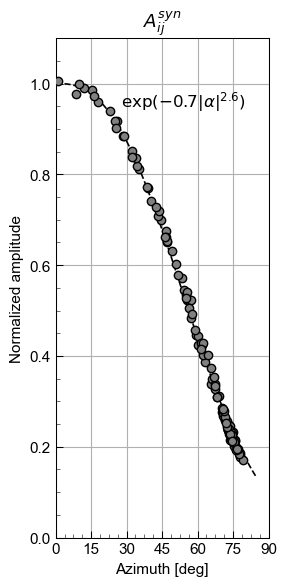

In [25]:
# Kwiatek 2014 plot
# Assign weight within 60 degrees to minimize the bias with the large incident angle
bell_sigma = np.ones(Nd)
for i, th in enumerate(df_disttheta.alpha):
    if np.abs(th) < 30:
        bell_sigma[i] = 0.1; # assign small variance for shallow azimuth
    if np.abs(th) > 60:
        bell_sigma[i] = 2; # assign large variance leading small weight
                
popt, pcov = curve_fit(model_bell, df_disttheta.alpha, Aksyn * df_disttheta.r, sigma=bell_sigma, absolute_sigma=True)
theta_syn = np.linspace(0, 85, 101)
A_bellsyn = model_bell(theta_syn, popt[0], popt[1], popt[2])
# compute bellcurve fit to synthetic radiation pattern
fig, ax = plt.subplots(1, 1, figsize=(3, 6), sharex=True)
markersize = 10
xlimit=[0, 90]
ylimit=[0, 1.1]

A0, exp_a, exp_b = popt
ax.plot(np.abs(df_disttheta.alpha), Aksyn * df_disttheta.r/A0, "o", markerfacecolor='gray', markeredgewidth=1.0, markeredgecolor='k', zorder=3)
ax.plot(theta_syn, A_bellsyn/A0, "k", lw=1.2, ls='--', zorder=2)

# annotate exponent coefficient
ax.text(27.5, 0.95, r"$\exp(-{%4.1f}|\alpha|^{{%4.1f}})$"%(exp_a, exp_b), fontsize=12)

ax.set_xlim(xlimit)
ax.set_ylim(ylimit)
ax.set_xticks([0, 15, 30, 45, 60, 75, 90])
ax.set_xlabel("Azimuth [deg]")
ax.set_ylabel("Normalized amplitude")
ax.set_title(r"$A_{ij}^{syn}$")
ax.grid(True)

plt.tight_layout()
plt.savefig(figdir+"/kwiatekplot_surface_syn.png", format="png", dpi=70)

In [26]:
popt

array([0.03672494, 0.72786284, 2.59427821])

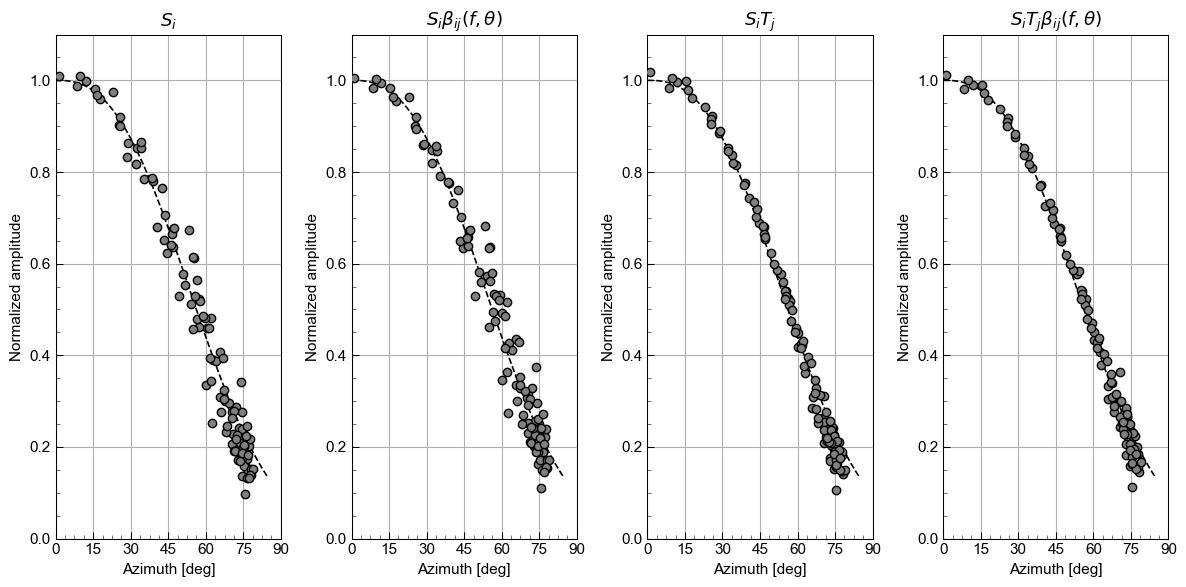

In [27]:
fig, axs = plt.subplots(1, 4, figsize=(12, 6), sharex=True)
model_order=["model1", "model3", "model2", "model4"]
# modelname = [r"$A_{ij}^{obs}/S_{i}$", r"$A_{ij}^{obs}/ S_{i}\alpha_{ij}(\theta)$", r"$A_{ij}^{obs}/ S_{i} T_{j}$", r"$A_{ij}^{obs}/ S_{i} T_{j} \alpha_{ij}(\theta)$"]
modelname = [r"$S_{i}$", r"$S_{i}\beta_{ij}(f, \theta)$", r"$S_{i} T_{j}$", r"$S_{i} T_{j} \beta_{ij}(f, \theta)$"]
markerfacecolor = 'gray'
plt.rc('text', usetex=False)
for i, model in enumerate(model_order):

    axs[i].plot(theta_syn, A_bellsyn/A0,"k", lw=1.2, ls='--', zorder=2)
    axs[i].plot(np.abs(df_disttheta.alpha), df_Akest[model]*df_disttheta.r/A0,  "o", markerfacecolor=markerfacecolor, markeredgewidth=1.0,
                    markeredgecolor='k', zorder=3)
    axs[i].set_xlim(xlimit)
    axs[i].set_ylim(ylimit)
    axs[i].set_xticks([0, 15, 30, 45, 60, 75, 90])
    axs[i].set_xlabel("Azimuth [deg]")
    axs[i].set_ylabel("Normalized amplitude")
    axs[i].set_title(modelname[i])
    axs[i].grid(True)
    
plt.tight_layout()
plt.savefig(figdir+"/kwiatekplot_surface_obs.png", format="png", dpi=70)
# plt.savefig(figdir+"/kwiatekplot_surface_obs.eps", format="eps", dpi=70)


## Compute residuals

The residual is obtained as follows:

$$\text{res} = \sqrt{\sum \left(A^{\text{obs}}-A^{\text{model}}\right)^2}.  $$

When the unit of $A$ is (m/s), the unit of the residual is also (m/s).

In [28]:
res_scaled_unit_vel = np.sqrt(np.square(df_res).sum(axis=0)[model_order]).values * 1e3 #[m/s] -> [mm/s]
res_scaled_unit_vel

array([0.08380217, 0.07780335, 0.03417734, 0.02495403])

## Compute AIC

We computed the AIC (Akaike, 1974) of the models such as

$$ \mathrm{AIC} = N \ln {\dfrac{1}{N} \sum_{i, j} \left( A_{ij}^{\text{obs}}-A_{ij}^{\text{model}} \right)^2} + 2k ,$$
where $N$ is the number of data used for the inversion, and $k$ is the number of the model parameters. 

The number of model parameters is following:

|  | k |
| ---- | ---- |
| model 1 | 32 (number of sensor) |
| model 2 | 64 (number of source + sensor)|
| model 3 | 33 (number of sensor + TR for beta)|
| model 4 | 65 (number of source + sensor + TR for beta)|

We compute the residual in the unit of (mm/s) to compute the AIC.

In [29]:
Nd, Ns, Nb

(117, 32, 32)

In [30]:
num_modelparam = {"model1":Ns, "model2":Ns+Nb, "model3":Ns+1, "model4":Ns+Nb+1}
num_modelparam

{'model1': 32, 'model2': 64, 'model3': 33, 'model4': 65}

In [31]:
for mid in model_order:
    res_model = df_res[mid]
    AIC_calc1 = Nd*np.log(np.square(res_model).sum(axis=0)/Nd) + 2*num_modelparam[mid]
    print(AIC_calc1)
    assert(np.abs(df_AIC[mid].values[0]-AIC_calc1) < 1e-3)

-2689.744437889573
-2705.1246395133085
-2835.618085708071
-2907.217564826423


In [32]:
# Compute the AIC with the residual unit of mm/s
AIC_scaled_unit_vel = []
for mid in model_order:
    res_model = df_res[mid]
    AIC_calc2 = Nd*np.log(np.square(res_model*1e3).sum(axis=0)/Nd) + 2*num_modelparam[mid]
    AIC_scaled_unit_vel.append(AIC_calc2)

In [33]:
AIC_scaled_unit_vel

[-1073.3297026077526,
 -1088.7099042314883,
 -1219.2033504262506,
 -1290.8028295446031]

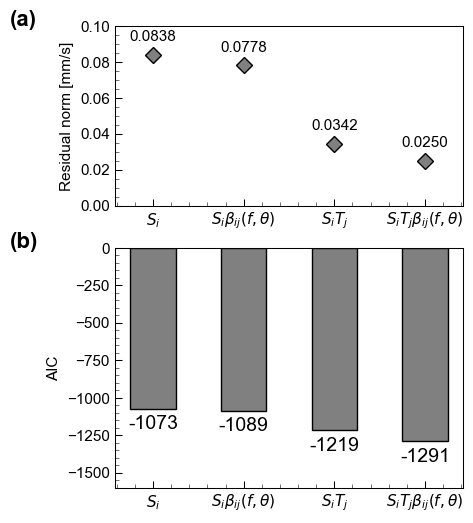

In [34]:
# Plot AIC and residual
# f, axs = plt.subplots(2, 1, gridspec_kw={'height_ratios': [2, 1]}, figsize=(5, 6), sharex=True)
# for notation
f = mticker.ScalarFormatter(useOffset=False, useMathText=True)
g = lambda x, pos : "{:3.4f}".format(x)
fmt = mticker.FuncFormatter(g)

fig = plt.figure(figsize=(4.5, 6))
gs = gridspec.GridSpec(2, 1, height_ratios=[1.5, 2]) 
xcase = [r"$S_{i}$", r"$S_{i}\beta_{ij}(f, \theta)$", r"$S_{i} T_{j}$", r"$S_{i} T_{j} \beta_{ij}(f, \theta)$"]

ax1 = plt.subplot(gs[0])

ax1.plot(xcase, res_scaled_unit_vel, "D", ms=8, markerfacecolor='gray', markeredgecolor='black')
ax1.set_ylim(0.0, 0.1)
ax1.set_ylabel("Residual norm [mm/s]")
# ax1.grid(True, which='major')
# ax1.set_yscale('log')

# plot values near marker 
vspace=0.008
ax1.text(0., res_scaled_unit_vel[0]+vspace, "{}".format(fmt(res_scaled_unit_vel[0])), ha="center")
ax1.text(1., res_scaled_unit_vel[1]+vspace, "{}".format(fmt(res_scaled_unit_vel[1])), ha="center")
ax1.text(2, res_scaled_unit_vel[2]+vspace, "{}".format(fmt(res_scaled_unit_vel[2])), ha="center")
ax1.text(3, res_scaled_unit_vel[3]+vspace, "{}".format(fmt(res_scaled_unit_vel[3])), ha="center")

ax2 = plt.subplot(gs[1], sharex=ax1)
# ax2.grid(True)
ax2.bar(xcase, AIC_scaled_unit_vel, width=0.5, color='gray', edgecolor="black", linewidth=1, zorder=3)
ax2.set_ylabel("AIC")
ax2.set_ylim([-1600, 0])

# plot values near bar 
vspace=-40
ax2.text(0, AIC_scaled_unit_vel[0]+vspace, "{:4.0f}".format(AIC_scaled_unit_vel[0]), ha="center", va="top", fontsize=14)
ax2.text(1, AIC_scaled_unit_vel[1]+vspace, "{:4.0f}".format(AIC_scaled_unit_vel[1]), ha="center", va="top", fontsize=14)
ax2.text(2, AIC_scaled_unit_vel[2]+vspace, "{:4.0f}".format(AIC_scaled_unit_vel[2]), ha="center", va="top", fontsize=14)
ax2.text(3, AIC_scaled_unit_vel[3]+vspace, "{:4.0f}".format(AIC_scaled_unit_vel[3]), ha="center", va="top", fontsize=14)

ax1.text(-0.3, 1.0, "(a)", transform=ax1.transAxes, size=16, weight='bold')
ax2.text(-0.3, 1.0, "(b)", transform=ax2.transAxes, size=16, weight='bold')
plt.savefig(figdir+"/FigS_surfaceeffect_AIC.png", format="png", dpi=70, bbox_inches="tight")
plt.savefig(figdir+"/FigS_surfaceeffect_AIC.eps", format="eps", bbox_inches="tight")


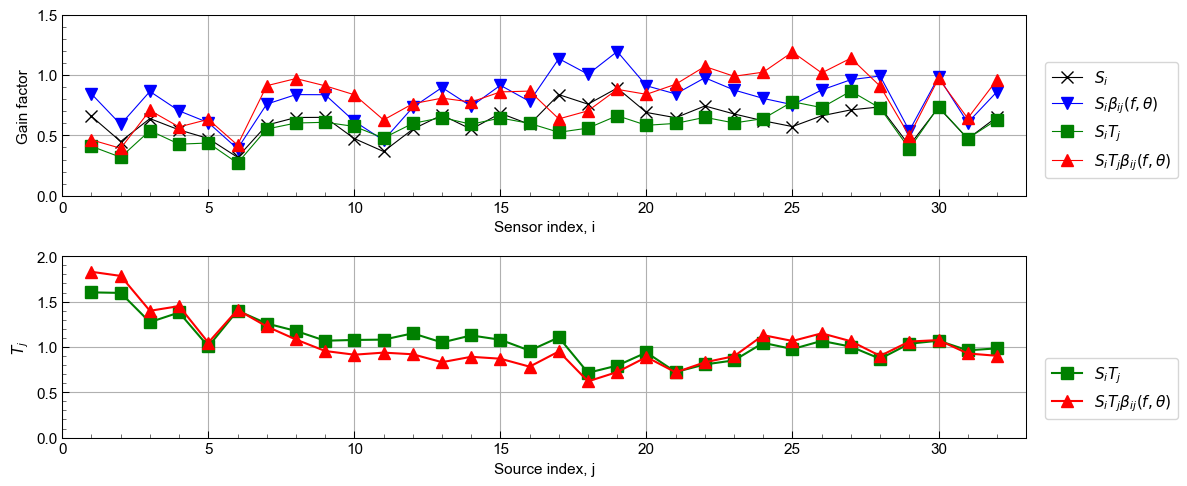

In [35]:
# We plot the gain factor, not the gain of transfer function
# Gain and source impact
fig, axs = plt.subplots(2, 1, figsize=(12, 5))
sensorid = np.array(range(Ns))+1
mts = ["x", "v", "s", "^"]
lcs = ["black", "blue", "green", "red"]
for i, model in enumerate(model_order):
    axs[0].plot(sensorid, df_Si[model], label=xcase[i], marker=mts[i], linestyle="-", color=lcs[i], markersize=8, lw=0.8)
    
axs[0].legend(loc=(1.02,0.1))
axs[0].set_xlim(0, Ns+1)
axs[0].set_ylim(0, 1.5)
axs[0].set_xlabel("Sensor index, i")
axs[0].set_ylabel("Gain factor")
axs[0].grid(True)


modelname = [r"$S_{i}$", r"$S_{i}\beta_{ij}(T_R, \theta)$", r"$S_{i} T_{j}$", r"$S_{i} T_{j} \beta_{ij}(T_R, \theta)$"]

model_order_Tj=["model2", "model4"]
xcase_Tj = [r"$S_{i} T_{j}$", r"$S_{i} T_{j} \beta_{ij}(T_R, \theta)$"]

for i in [2, 3]:
    axs[1].plot(sensorid, df_Tj[model_order[i]], label=xcase[i], marker=mts[i], linestyle="-", color=lcs[i], markersize=8)
    
axs[1].legend(loc=(1.02,0.1))
axs[1].set_xlim(0, Ns+1)
axs[1].set_ylim(0, 2.0)
axs[1].set_xlabel("Source index, j")
axs[1].set_ylabel("$T_{j}$")
axs[1].grid(True)

fig.tight_layout()
plt.savefig(figdir+"/SiandTj_surface.png", format="png", dpi=70)


In [36]:
# plot gain and sensor coefficient with distance x; for model 4
model2_Si = df_Si.model2.values
model2_Tj = df_Tj.model2.values
model4_Si = df_Si.model4.values
model4_Tj = df_Tj.model4.values
sensor_x = [channel_loc[x][0] for x in AEsensors]
source_x = df_location.X.values

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


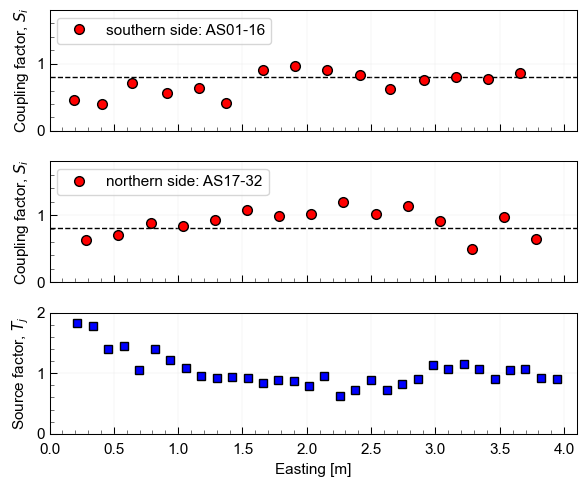

In [37]:
# Gain and source impact for model 4
fig, axs = plt.subplots(3, 1, figsize=(6, 5), sharex=True)
sensorid = np.array(range(Ns))+1
mts = ["x", "v", "s", "^"]
lcs = ["black", "blue", "green", "red"]
ms = 7

axs[0].plot(np.array(sensor_x[0:15])/1e3, model4_Si[0:15], marker="o", linestyle="", c='k', markersize=ms, lw=0.8, markerfacecolor="r", markeredgecolor="k", label="southern side: AS01-16")
axs[0].legend(loc=2)
axs[0].axhline(np.mean(model4_Si), color='k', ls="--", lw=1, zorder=-1)
axs[0].set_xlim(0, 4.1)
axs[0].set_ylim(0, 1.8)
# axs[0].set_xlabel("Distance [mm]")
axs[0].set_ylabel("Coupling factor, $S_{i}$")


axs[1].plot(np.array(sensor_x[16:31])/1e3, model4_Si[16:31], marker="o", linestyle="", c='k', markersize=ms, lw=0.8, markerfacecolor="r", markeredgecolor="k", label="northern side: AS17-32")
axs[1].legend(loc=2)
axs[1].axhline(np.mean(model4_Si), color='k', ls="--", lw=1, zorder=-1)
axs[1].set_xlim(0, 4.1)
axs[1].set_ylim(0, 1.8)
# axs[1].set_xlabel("Distance [mm]")
axs[1].set_ylabel("Coupling factor, $S_{i}$")


modelname = [r"$S_{i}$", r"$S_{i}\beta_{ij}(T_R, \theta)$", r"$S_{i} T_{j}$", r"$S_{i} T_{j} \beta_{ij}(T_R, \theta)$"]

axs[2].plot(source_x, model4_Tj, marker="s", linestyle="", c="k", markerfacecolor="b", markeredgecolor="k", markersize=ms-1)
    
# axs[1].legend(loc=(1.02,0.1))
axs[2].set_xlim(0, 4.1)
axs[2].set_ylim(0, 2.0)
axs[2].set_yticks([0, 1, 2])
axs[2].set_xlabel("Easting [m]")
axs[2].set_ylabel("Source factor, $T_{j}$")
axs[2].tick_params(axis='x', pad=7)

for i in range(3):
    axs[i].grid(True, c=np.array([230, 230, 230])/255, lw=0.25, which="major",)
    axs[i].set_axisbelow('True')

fig.align_ylabels(axs[:])

fig.tight_layout()
plt.savefig(figdir+"/FigS_SiandTj_withdistancex_surface_model4.png", format="png", dpi=70)
plt.savefig(figdir+"/FigS_SiandTj_withdistancex_surface_model4.eps", format="eps")


In [38]:
np.mean(model4_Si)

0.8093015350916795

In [39]:
len(sensor_x[0:16])

16

In [40]:
print(sensor_x[0:16])

[190.0, 410.0, 640.0, 910.0, 1160.0, 1370.0, 1660.0, 1910.0, 2160.0, 2410.0, 2650.0, 2910.0, 3160.0, 3410.0, 3660.0, 3910.0]


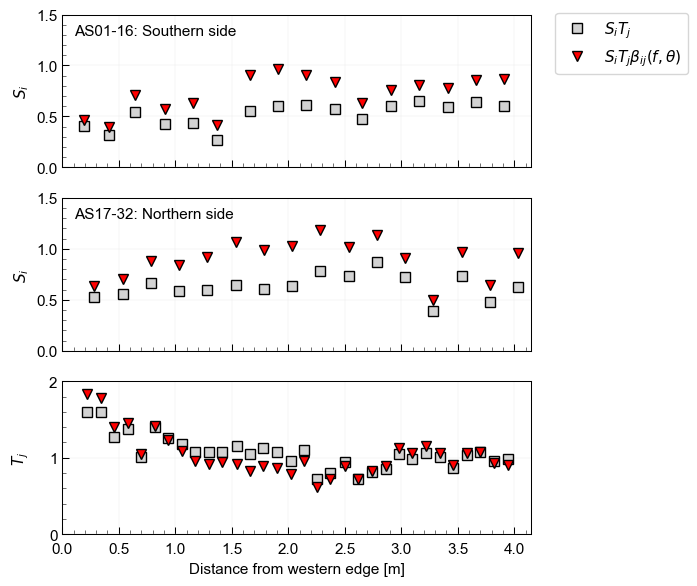

In [41]:
# Gain and source impact
fig, axs = plt.subplots(3, 1, figsize=(7.5, 6), sharex=True)
sensorid = np.array(range(Ns))+1
mts = ["x", "v", "s", "^"]
lcs = ["black", "blue", "green", "red"]
ms = 7
lw=0.25
axs[0].plot(np.array(sensor_x[0:16])/1e3, model2_Si[0:16], marker="s", linestyle="", c='k', markersize=ms, lw=lw, markerfacecolor="lightgray", markeredgecolor="k", label=r"$S_{i} T_{j}$")
axs[0].plot(np.array(sensor_x[0:16])/1e3, model4_Si[0:16], marker="v", linestyle="", c='r', markersize=ms, lw=lw, markerfacecolor="r", markeredgecolor="k", label=r"$S_{i} T_{j} \beta_{ij}(f, \theta)$")
# axs[0].axhline(np.mean(model4_Si), color='k', ls=":", zorder=-1)
axs[0].set_xlim(0, 4.15)
axs[0].set_ylim(0, 1.5)
# axs[0].set_xlabel("Distance [mm]")
axs[0].set_ylabel("$S_{i}$")
axs[0].text(0.1, 1.3, "AS01-16: Southern side")

axs[1].plot(np.array(sensor_x[16:32])/1e3, model2_Si[16:32], marker="s", linestyle="", c='k', markersize=ms, lw=lw, markerfacecolor="lightgray", markeredgecolor="k")
axs[1].plot(np.array(sensor_x[16:32])/1e3, model4_Si[16:32], marker="v", linestyle="", c='r', markersize=ms, lw=lw, markerfacecolor="r", markeredgecolor="k")
# axs[1].legend(loc=1)
# axs[1].axhline(np.mean(model4_Si), color='k', ls=":", zorder=-1)
axs[1].set_xlim(0, 4.15)
axs[1].set_ylim(0, 1.5)
# axs[1].set_xlabel("Distance [mm]")
axs[1].set_ylabel("$S_{i}$")
axs[1].text(0.1, 1.3, "AS17-32: Northern side")

modelname = [r"$S_{i}$", r"$S_{i}\beta_{ij}(f, \theta)$", r"$S_{i} T_{j}$", r"$S_{i} T_{j} \beta_{ij}(f, \theta)$"]

axs[2].plot(source_x, model2_Tj, marker="s", linestyle="", c="k", markerfacecolor="lightgray", markeredgecolor="k", markersize=ms, lw=lw)
axs[2].plot(source_x, model4_Tj, marker="v", linestyle="", c="r", markerfacecolor="r", markeredgecolor="k", markersize=ms, lw=lw)

# axs[1].legend(loc=(1.02,0.1))
axs[2].set_xlim(0, 4.15)
axs[2].set_ylim(0, 2)
axs[2].set_yticks([0, 1, 2])
axs[2].set_xlabel("Distance from western edge [m]")
axs[2].set_ylabel("$T_{j}$")
axs[2].tick_params(axis='x', pad=6)

# axs[2].legend(loc=1)

for i in range(3):
    axs[i].grid(True, c=np.array([230, 230, 230])/255, lw=0.25)
    axs[i].set_axisbelow('True')

axs[0].legend(bbox_to_anchor=(1.35, 1.06))

fig.align_ylabels(axs[:])

fig.tight_layout()
plt.savefig(figdir+"/SiandTj_withdistancex_surface_model3and4.png", format="png", dpi=70)
# plt.savefig(figdir+"/FigS_SiandTj_withdistancex_surface_model3and4.eps", format="eps")


In [42]:
# compute mean and std of gain for model 4
gain_mean = np.mean(model4_Si)
gain_std = np.std(model4_Si)
print(rf"The gain factor associated with the model 4 is obtained as {gain_mean:.4f} ± {gain_std:.4f}")

The gain factor associated with the model 4 is obtained as 0.8093 ± 0.2031


## Compute the emperical gain by comparing the observation in Voltage and the synthetics

To get the uniform gain of sensor, we compair the P wave amplitude between the observation before the removal of response and synthetics. The average value 40.36 [V/(m/s)] is documented in the article.

In [43]:
Aijobs_norem=pd.read_csv("../data/DATA_surfaceeffect_Aij_Case2/Aijobs_noremoval.csv", header=None).values
Aijsyn=pd.read_csv("../data/DATA_surfaceeffect_Aij_Case2/Aijsyn.csv", header=None).values
rij=pd.read_csv("../data/DATA_surfaceeffect_Aij_Case2/rij.csv", header=None).values # source distance

In [44]:
emp_gain_dist = []
emp_gain = []
for i in range(rij.shape[0]):
    for j in range(rij.shape[1]):
        if rij[i, j] != 0:
            emp_gain_dist.append(rij[i, j])
            emp_gain.append(Aijobs_norem[i, j]/Aijsyn[i, j])
            

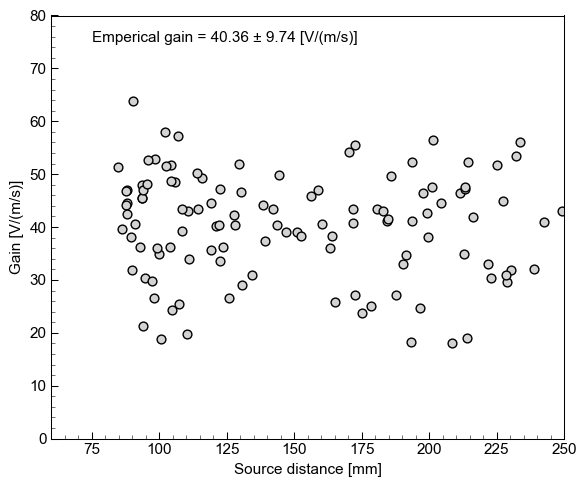

In [45]:
fig, ax = plt.subplots(1, 1, figsize=(6, 5))
preamp = 40 #[dB]
preamp_factor = 10**(preamp/20)
ax.scatter(emp_gain_dist, np.array(emp_gain)/preamp_factor, 40, marker="o", fc="lightgray", ec="k")
ax.set_xlim(60, 250)
ax.set_ylim(0, 80)
ax.set_xlabel("Source distance [mm]")
ax.set_ylabel("Gain [V/(m/s)]")
mean_gain = np.mean(np.array(emp_gain)/preamp_factor)
mean_std = np.std(np.array(emp_gain)/preamp_factor)

ax.text(75, 75, f"Emperical gain = {mean_gain:.2f} ± {mean_std:.2f} [V/(m/s)] ")

fig.tight_layout()
plt.savefig(figdir+"/Emperical_sensor_gain_to_velocity.png", format="png", dpi=70)
# plt.savefig(figdir+"/Emperical_sensor_gain_to_velocity.eps", format="eps", dpi=150)


# Save the master gain for AE sensor coupling

In [46]:
# model 3(renamed from model II) and 4

df_gainfactor_model2 = pd.DataFrame({'AEsensor':[], 'gainfactor':[]})
df_gainfactor_model4 = pd.DataFrame({'AEsensor':[], 'gainfactor':[]})
for i, stnm in enumerate(AEsensors):
#     scale_factor_sensor_model2 = df_Si["model2"][i] * scale_fac #[V/(m/s)]
    df_gainfactor_tmp2 = pd.DataFrame({'AEsensor':[stnm], 'gainfactor':[df_Si["model2"][i]]})
    df_gainfactor_model2 = pd.concat([df_gainfactor_model2, df_gainfactor_tmp2], ignore_index=True)
    
#     scale_factor_sensor_model4 = df_Si["model4"][i] * scale_fac #[V/(m/s)]
    df_gainfactor_tmp4 = pd.DataFrame({'AEsensor':[stnm], 'gainfactor':[df_Si["model4"][i]]})
    df_gainfactor_model4 = pd.concat([df_gainfactor_model4, df_gainfactor_tmp4], ignore_index=True)
    
    
# save to csv
df_gainfactor_model2.to_csv(root+"/master_gain_model2.csv")
df_gainfactor_model4.to_csv(root+"/master_gain_model4.csv")

The `master_gain_model4.csv` is used to correct for the AE waveforms in the main analysis.

# Plot waveform comparison

In [47]:
# sensitivity of surface effect
def incidentangle_scalingfactor_analytic(v, theta, TR, R):
    if theta==0:
        return 1.0
    else:
        va = v/np.sin(theta)
        J1 = mp.besselj(1, (2*np.pi*R)/(va*TR))
        return  ((va * TR)/(np.pi*R)) * J1

In [48]:
v = 6200
R = 6.35e-3 # 8.0e-3
TR_model4 = df_TR["model4"].values[0]
theta_vec=np.linspace(0, 90, 101)

kvec = np.array([incidentangle_scalingfactor_analytic(v, np.deg2rad(x), TR_model4, R) for x in theta_vec])

In [49]:
# define freqband
freqmin = 0.1e6 
freqmax = 1.0e6 #1.0e6
freqband = '{:.1f}-{:.1f}'.format(freqmin/1e6, freqmax/1e6)
vmean = 6200
pwin_len_pre = 5e-3 #[ms]: buffer of p window length to estimate gain
pwin_len = 1.5e-2 #[ms]: p window length to estimate gain
dist_p_threshold = 200 #300 #[mm]: use tpick within this threshold, otherwise use theoretical p arrival 


In [50]:
# parse beteeen index i and j and caseid
cij ={}

for index, row in df_indextable.iterrows():
    i, j = row
    stcaseid = df_caseid.iloc[index].values[0]
    stnm, caseid = stcaseid.split('__')
    if not stcaseid in cij:
        # append as new stcase
        cij[stcaseid] = [i, j]

OL18__BD_0220
OL18__BD_0820
OL18__BD_0340:[0.75827619 0.69325175 0.8942195  0.85891036]
OL18__BD_0460:[0.75827619 0.73410595 0.7134264  0.71398247]
OL18__BD_0580:[0.75827619 0.76736011 0.77322585 0.77469118]
OL18__BD_0700:[0.75827619 0.69822663 0.56297179 0.50816951]


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


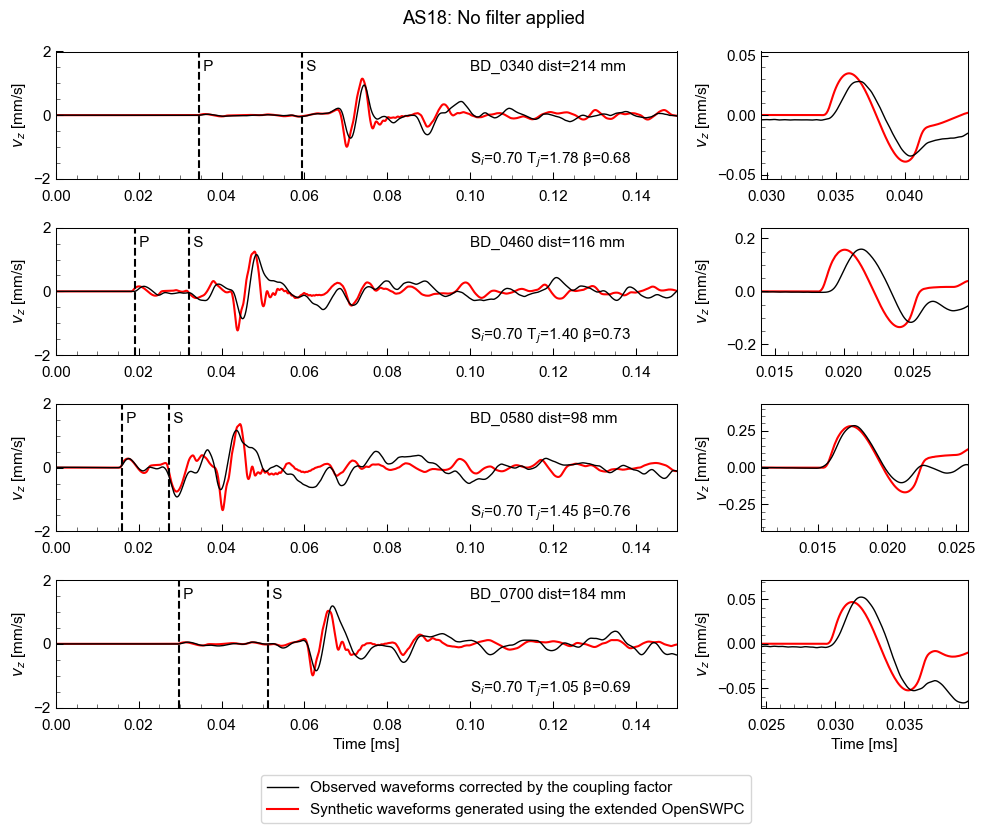

In [51]:
stnm_master='OL18'

ifBandPassFilter = False

vs_mean = 3600;

# trcount = 0

# for stnm in tqdm(AEsensors):
stnm = stnm_master

finame = os.path.join(bdwaveform_datadir, "{}_bdwaveform.pickle".format(stnm)) 
st = read(finame, format="PICKLE")

# prefilitering traces
# demean
st.detrend(type='demean')

# apply bandpass
if ifBandPassFilter:
    st.filter("bandpass", freqmin=freqmin, freqmax=freqmax, corners=4, zerophase=True) 

# apply taper
st.taper(max_percentage=0.001)   

# Select observation and synthetic
st_obs = st.select(channel='OY')
st_syn = st.select(channel='SY')

# Extract the traces used in the Si inversion
for i, tr_obs in enumerate(st_obs):
    if tr_obs.stats.dataindex not in np.squeeze(df_caseid.values):
        print(tr_obs.stats.dataindex)
        st_obs.remove(tr_obs)

Ntrace = len(st_obs)
if Ntrace==1:
    Ntrace=2 # tentatively we add the axis in the case of trace = 1

fig, axs = plt.subplots(Ntrace, 2, figsize=(10, 7.5), sharex=False, gridspec_kw={'width_ratios': [3, 1]})

lcs = ["blue", "orange", "green", "red"]
lts = ["--", ":", "-", "-"]

# Plot parameters
xlimit_wf = [0, 0.15] 
ylimit_wf = [-2.0, 2.]

yticks = [-2., 0.0, 2.]

for i, tr_obs in enumerate(st_obs):

        dataindex = tr_obs.stats.dataindex
        tr_syn = list(filter(lambda tr: tr.stats.dataindex == dataindex, st_syn))[0]

        dist = tr_obs.stats.dist #[mm]

        if dist <= dist_p_threshold:
            p_theoretical = tr_obs.stats.tpick
        else:
            p_theoretical = dist/vmean

        s_theoretical = dist/vs_mean
        
        tvec = np.array(range(0, tr_syn.stats.npts))*tr_syn.stats.delta*1e3 - tr_obs.stats.pretrigger #[ms]

        #---compute correction coefficient from Si, Tj and alpha(theta)---#
        amp_correction = np.zeros(4) # 4 models
        ii, jj = [cij[dataindex][0]-1, cij[dataindex][1]-1]
        kk = df_caseid.index[df_caseid.caseid == dataindex][0]

        Asyn = Aksyn[kk]

        # model 1: gain model
        Si1 = df_Si["model1"][ii]
        amp_correction[0] = Si1

        # model 3: directionality-dominant
        Si3 = df_Si["model3"][ii]
        theta3 = df_disttheta["theta"][kk]
        TR3 = df_TR["model3"][0]
        k3 = incidentangle_scalingfactor_analytic(v, np.deg2rad(theta3), TR3, R)
        amp_correction[1] = Si3*k3

        #model 2: source impact-dominant
        Si2 = df_Si["model2"][ii]
        Tj2 = df_Tj["model2"][jj]
        amp_correction[2] = Si2*Tj2

        # model 4: mix model
        Si4 = df_Si["model4"][ii]
        Tj4 = df_Tj["model4"][jj]
        theta4 = df_disttheta["theta"][kk]
#             alpha4 = model_bell(theta4, 1.0, a4, b4) # bell-shape 
        TR4 = df_TR["model4"][0]
        k4 = incidentangle_scalingfactor_analytic(v, np.deg2rad(theta4), TR4, R)

        amp_correction[3] = Si4*Tj4*k4

#         ampfactor_comparison = np.vstack((ampfactor_comparison, [df_disttheta["theta"][kk], 
#                         amp_correction[3]/amp_correction[0],  amp_correction[3]/amp_correction[1], amp_correction[3]/amp_correction[2]]))

        #---------------------------------------------------------------------------------#
        print(dataindex+":"+str(amp_correction))
        # plot synthetic waveform
        p0 = axs[i, 0].plot(tvec, 1e3*tr_syn.data, 'r-', label='synthetic', zorder=1)
        axs[i, 1].plot(tvec, 1e3*tr_syn.data, 'r-', label='synthetic', zorder=1)

        # plot corrected observation
        axs[i, 0].plot(tvec, 1e3*tr_obs.data/amp_correction[-1], "k-", lw=1., label='obs', zorder=2) # use the best model with model 4
        axs[i, 1].plot(tvec, 1e3*tr_obs.data/amp_correction[-1], "k-", lw=1., label=xcase[-1], zorder=2)
    

        # all waveform
        axs[i, 0].axvline(p_theoretical, c = 'k', ls = '--')
        axs[i, 0].axvline(s_theoretical, c = 'k', ls = '--')
        axs[i, 0].set_xlim(xlimit_wf)
        axs[i, 0].set_ylim(ylimit_wf)
        axs[i, 0].set_yticks(yticks)
        axs[i, 0].set_ylabel('$v_z$ [mm/s]')
#         axs[i, 0].legend(loc=1)
        axs[i, 0].tick_params(axis='x', pad=8)

        # pwave window
        xlimit_wf_p = [p_theoretical-pwin_len_pre, p_theoretical-pwin_len_pre+pwin_len]
#         ylimit_wf_p = [-0.6, 0.6]
        ylimit_wf_p = np.array([-Asyn, Asyn])*1.5e3
#         print(ylimit_wf_p)
#         axs[i, 1].axvline(p_theoretical-pwin_len_pre, c = 'k', ls = '--')
#         axs[i, 1].axvline(p_theoretical+pwin_len , c = 'k', ls = '--')
        axs[i, 1].set_xlim(xlimit_wf_p)
        axs[i, 1].set_ylim(ylimit_wf_p)
#         axs[i, 1].set_yticks()
        axs[i, 1].set_ylabel('$v_z$ [mm/s]')
#         axs[i, 0].legend(loc=1)
        axs[i, 1].tick_params(axis='x', pad=8)

        # print source distance
        axs[i, 0].text(p_theoretical, 1.4, " P", ha="left")
        axs[i, 0].text(s_theoretical, 1.4, " S", ha="left")
        axs[i, 0].text(0.1, 1.4, f"BD_{tr_obs.stats.location} dist={tr_obs.stats.dist:.0f} mm")
        axs[i, 0].text(0.1, -1.42, rf"S$_i$={Si4:.2f} T$_j$={Tj4:.2f} β={float(k4):.2f}", va="center")
        
axs[-1, 0].set_xlabel('Time [ms]')
axs[-1, 1].set_xlabel('Time [ms]')
if ifBandPassFilter:
    title =  'AS{} Bandpass: {} MHz'.format(stnm[2:], freqband)
else:
    title = 'AS{}: No filter applied'.format(stnm[2:])
    
plt.suptitle(title)
fig.tight_layout()

# legend
fig.subplots_adjust(bottom=0.05)
legend_ax = fig.add_axes([0.26, -0.08, 0.3, 0.05])

lines = axs[0, 0].get_lines()
legend_ax.set_axis_off()
legend_ax.legend(lines[0:2][::-1], ["Observed waveforms corrected by the coupling factor", 
                                   "Synthetic waveforms generated using the extended OpenSWPC"], loc="upper left")
handles, labels = plt.gca().get_legend_handles_labels()

if not os.path.exists(figdir+"/bdwaveform_SiTjcorrect"):
    os.makedirs(figdir+"/bdwaveform_SiTjcorrect")

fig.align_ylabels(axs[:, 0])
fig.align_ylabels(axs[:, 1])

if ifBandPassFilter:
    foname = figdir+f"/bdwaveform_SiTjcorrect/bdwaveform_comparison_{stnm}_{freqband}MHz"
else:
    foname = figdir+f"/bdwaveform_SiTjcorrect/bdwaveform_comparison_{stnm}_nofilter"
    
plt.savefig(foname+".png", dpi=100, bbox_inches="tight")
plt.savefig(foname+".eps", bbox_inches="tight")


In [52]:
# Compute the optimized omega for the aperture effect term
f_beta_model4 = 1/df_TR["model4"].values[0]
print(f"Optimized frequency of aperture effect: {f_beta_model4/1e3:.2f} kHz")

Optimized frequency of aperture effect: 269.47 kHz
